In [52]:
import QuantLib as ql

In [53]:
# setup Dates
cal = ql.TARGET()
todaysDate = ql.Date(9,6,2023)
shiftUnit = ql.Period(2, ql.Days)
settlementDate = cal.advance(todaysDate, shiftUnit, ql.ModifiedFollowing, False)
ql.Settings.instance().evaluationDate = todaysDate
print(f'Today is {todaysDate.ISO()}')
print(f'Settlement Date is {settlementDate.ISO()}')

Today is 2023-06-09
Settlement Date is 2023-06-13


In [54]:
# setup market quotes data
# Money Market rate
d1wQuote = 0.0382
d1mQuote = 0.0372
d3mQuote = 0.0363
d6mQuote = 0.0353
d9mQuote = 0.0348
d1yQuote = 0.0345
# swap rate
s2yQuote = 0.037125
s3yQuote = 0.0398
s5yQuote = 0.0443
s10yQuote = 0.05165
s15yQuote = 0.055175

# define Quotes
# SimpleQuotes stores a value which can be manually changed;
# deposit rate (money market rate)
d1wRate = ql.QuoteHandle(ql.SimpleQuote(d1wQuote))
d1mRate = ql.QuoteHandle(ql.SimpleQuote(d1mQuote))
d3mRate = ql.QuoteHandle(ql.SimpleQuote(d3mQuote))
d6mRate = ql.QuoteHandle(ql.SimpleQuote(d6mQuote))
d9mRate = ql.QuoteHandle(ql.SimpleQuote(d9mQuote))
d1yRate = ql.QuoteHandle(ql.SimpleQuote(d1yQuote))
# swap rates
s2yRate = ql.QuoteHandle(ql.SimpleQuote(s2yQuote))
s3yRate = ql.QuoteHandle(ql.SimpleQuote(s3yQuote))
s5yRate = ql.QuoteHandle(ql.SimpleQuote(s5yQuote))
s10yRate = ql.QuoteHandle(ql.SimpleQuote(s10yQuote))
s15yRate = ql.QuoteHandle(ql.SimpleQuote(s15yQuote))

Rate Helpers
RateHelpers are built from the above quotes together with other instrument dependant infos.  Quotes are passed in relinkable handles which could be relinked to some other data source later.

In [55]:
fixingDays = 2
endOfMonth = False
# deposits
depositDayCounter = ql.Actual360()
# there's error when we using Qutoe object for creating instance
d1w = ql.DepositRateHelper(d1wRate, ql.Period('1W'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)
d1m = ql.DepositRateHelper(d1mRate, ql.Period('1M'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)
d3m = ql.DepositRateHelper(d3mRate, ql.Period('3M'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)
d6m = ql.DepositRateHelper(d6mRate, ql.Period('6M'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)
d9m = ql.DepositRateHelper(d9mRate, ql.Period('9M'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)
d1y = ql.DepositRateHelper(d1yRate, ql.Period('1Y'), fixingDays, cal, ql.ModifiedFollowing, endOfMonth,depositDayCounter)

# swap instruments
swFixedLegFrequency = ql.Annual
swFixedLegConvention = ql.Unadjusted
swFixedLegDayCounter = ql.Thirty360(ql.Thirty360.European)

swFloatingLegIndex = ql.Euribor6M()

s2y = ql.SwapRateHelper(s2yRate, ql.Period('2Y'), cal, swFixedLegFrequency, swFixedLegConvention, swFixedLegDayCounter, swFloatingLegIndex)
s3y = ql.SwapRateHelper(s3yRate, ql.Period('3Y'), cal, swFixedLegFrequency, swFixedLegConvention, swFixedLegDayCounter, swFloatingLegIndex)
s5y = ql.SwapRateHelper(s5yRate, ql.Period('5Y'), cal, swFixedLegFrequency, swFixedLegConvention, swFixedLegDayCounter, swFloatingLegIndex)
s10y = ql.SwapRateHelper(s10yRate, ql.Period('10Y'), cal, swFixedLegFrequency, swFixedLegConvention, swFixedLegDayCounter, swFloatingLegIndex)
s15y = ql.SwapRateHelper(s15yRate, ql.Period('15Y'), cal, swFixedLegFrequency, swFixedLegConvention, swFixedLegDayCounter, swFloatingLegIndex)


Curve Building

In [56]:
termStructureDayCounter = ql.ActualActual(ql.ActualActual.ISDA) 
tolerance = 1.0e-15

#build curve
helpers = ql.RateHelperVector()
helpers.append(d1w)
helpers.append(d1m)
helpers.append(d3m)
helpers.append(d6m)
helpers.append(d9m)
helpers.append(d1y)
helpers.append(s2y)
helpers.append(s3y)
helpers.append(s5y)
helpers.append(s10y)
helpers.append(s15y)

depoSwapTermStructure = ql.PiecewiseLogLinearDiscount(todaysDate, helpers, termStructureDayCounter)

settlementDF = depoSwapTermStructure.discount(settlementDate)
print(settlementDF)
discFactors=[]
for d in depoSwapTermStructure.dates():
    date = d.ISO()
    timeFrom = depoSwapTermStructure.timeFromReference(d)
    zero = depoSwapTermStructure.zeroRate(d, ql.Actual365Fixed(), ql.Continuous)
    disc = depoSwapTermStructure.discount(d)
    discData = {'Date': date,'TimeFrom':timeFrom,'ZeroRate':zero.rate()*100.0, 'Discount': disc}
    discFactors.append(discData)


0.999575803108445


In [57]:
import pandas as pd

discData = pd.DataFrame(discFactors)
display(discData)

,Date,TimeFrom,ZeroRate,Discount
0,2023-06-09,0.000000,3.871618,1.000000
1,2023-06-20,0.030137,3.871618,0.998834
2,2023-07-13,0.093151,3.778278,0.996487
3,2023-09-13,0.263014,3.672124,0.990388
4,2023-12-13,0.512329,3.554233,0.981955
5,2024-03-13,0.761105,3.488016,0.973784
6,2024-06-13,1.012471,3.442658,0.965704
7,2025-06-13,2.010959,3.645170,0.929227
8,2026-06-15,3.016438,3.905072,0.888784
9,2028-06-13,5.012471,4.367631,0.803242


<Axes: xlabel='TimeFrom', ylabel='ZeroRate'>

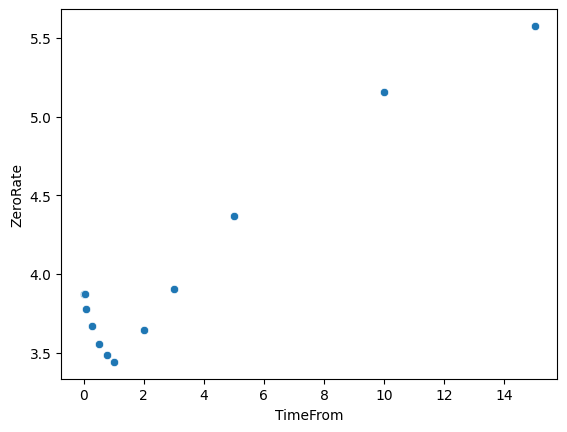

In [58]:
import seaborn as sns

sns.scatterplot(x='TimeFrom', y='ZeroRate', data=discData)
